In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os
import tiktoken

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.6.0+cu124
CUDA available: True


In [2]:
import numpy as np

dtype = np.uint16

train_path = "/kaggle/input/tiny-stories-bin-files/train.bin"
val_path = "/kaggle/input/tiny-stories-bin-files/validation.bin"

train_arr = np.memmap(train_path, dtype=dtype, mode='r')
validation_arr = np.memmap(val_path, dtype=dtype, mode='r')

print(f"Training data size: {len(train_arr):,} tokens")
print(f"Validation data size: {len(validation_arr):,} tokens")
print(f"Training data first 10 tokens: {train_arr[:10]}")
print(f"Validation data first 10 tokens: {validation_arr[:10]}")

Training data size: 471,872,517 tokens
Validation data size: 4,743,928 tokens
Training data first 10 tokens: [ 3198  1110    11   257  1310  2576  3706 20037  1043   257]
Validation data first 10 tokens: [32565    13 15899  2497   262 22441  1097   290   531    11]


In [3]:
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)


class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True


class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

print("Model architecture defined successfully!")

Model architecture defined successfully!


In [4]:
# Training Config
learning_rate = 1e-4
max_iters = 20000
warmup_steps = 1000
min_lr = 5e-4
eval_iters = 500
batch_size = 32
block_size = 128
gradient_accumulation_steps = 32

checkpoint_interval = 500
checkpoint_path = "training_checkpoint.pt"
best_model_params_path = "best_model_params.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu'

dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"Device: {device}")
print(f"Device type: {device_type}")
print(f"Data type: {dtype}")
print(f"Checkpoint will be saved every {checkpoint_interval} iterations")

Device: cuda
Device type: cuda
Data type: bfloat16
Checkpoint will be saved every 500 iterations


In [5]:
train_bin_path = "/kaggle/input/tiny-stories-bin-files/train.bin"
val_bin_path = "/kaggle/input/tiny-stories-bin-files/validation.bin"

def get_batch(split):
    if split == 'train':
        data = np.memmap(train_bin_path, dtype=np.uint16, mode='r')
    else:
        data = np.memmap(val_bin_path, dtype=np.uint16, mode='r')
    
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    
    if device_type == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    
    return x, y

print("Testing get_batch function...")
X_test, y_test = get_batch('train')
print(f"Batch shape: X={X_test.shape}, y={y_test.shape}")
print(f"Batch device: {X_test.device}")

Testing get_batch function...
Batch shape: X=torch.Size([32, 128]), y=torch.Size([32, 128])
Batch device: cuda:0


In [6]:
config = GPTConfig(
    vocab_size=50257,
    block_size=128,
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model is on device: {next(model.parameters()).device}")

Total parameters: 29,995,392
Trainable parameters: 29,995,392
Model is on device: cuda:0


In [7]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

print("Loss estimation function defined!")

Loss estimation function defined!


In [8]:
def save_checkpoint(model, optimizer, scheduler, scaler, epoch, train_loss_list, validation_loss_list, best_val_loss, filepath):
    """Save training checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'train_loss_list': train_loss_list,
        'validation_loss_list': validation_loss_list,
        'best_val_loss': best_val_loss,
        'config': config,
        'rng_state': torch.get_rng_state(),
        'cuda_rng_state': torch.cuda.get_rng_state() if torch.cuda.is_available() else None,
    }
    torch.save(checkpoint, filepath)
    print(f"✓ Checkpoint saved at epoch {epoch}")


def load_checkpoint(model, optimizer, scheduler, scaler, filepath):
    """Load training checkpoint"""
    if os.path.exists(filepath):
        print(f"Loading checkpoint from {filepath}...")
        checkpoint = torch.load(filepath, map_location=device)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
        
        torch.set_rng_state(checkpoint['rng_state'])
        if torch.cuda.is_available() and checkpoint['cuda_rng_state'] is not None:
            torch.cuda.set_rng_state(checkpoint['cuda_rng_state'])
        
        start_epoch = checkpoint['epoch'] + 1
        train_loss_list = checkpoint['train_loss_list']
        validation_loss_list = checkpoint['validation_loss_list']
        best_val_loss = checkpoint['best_val_loss']
        
        print(f"✓ Checkpoint loaded! Resuming from epoch {start_epoch}")
        print(f"✓ Best validation loss so far: {best_val_loss:.4f}")
        
        return start_epoch, train_loss_list, validation_loss_list, best_val_loss
    else:
        print("No checkpoint found. Starting from scratch.")
        return 0, [], [], float('inf')


print("Checkpoint functions defined!")

Checkpoint functions defined!


In [9]:
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9)

scheduler_warmup = LinearLR(optimizer, start_factor=1.0, end_factor=1.0, total_iters=warmup_steps)
scheduler_decay = CosineAnnealingLR(optimizer, T_max=max_iters - warmup_steps, eta_min=min_lr)
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps])

scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

print("Optimizer and scheduler initialized!")

Optimizer and scheduler initialized!


/tmp/ipykernel_19/1845446616.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [10]:
start_epoch, train_loss_list, validation_loss_list, best_val_loss = load_checkpoint(
    model, optimizer, scheduler, scaler, checkpoint_path
)

print(f"\nStarting training from epoch {start_epoch}...")
print(f"Will train until epoch {max_iters}")

model.train()

for epoch in tqdm(range(start_epoch, max_iters), initial=start_epoch, total=max_iters):
    if epoch % eval_iters == 0 and epoch != 0:
        losses = estimate_loss(model)
        print(f"\nEpoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list.append(losses['train'])
        validation_loss_list.append(losses['val'])

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)
            print(f"✓ New best model saved! Val loss: {best_val_loss:.4f}")

    if epoch % checkpoint_interval == 0 and epoch != 0:
        save_checkpoint(model, optimizer, scheduler, scaler, epoch, 
                       train_loss_list, validation_loss_list, best_val_loss, checkpoint_path)

    X, y = get_batch("train")
    
    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
    
    scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    
    scheduler.step()

save_checkpoint(model, optimizer, scheduler, scaler, max_iters - 1, 
               train_loss_list, validation_loss_list, best_val_loss, checkpoint_path)

print("\n" + "="*50)
print("Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")
print("="*50)

No checkpoint found. Starting from scratch.

Starting training from epoch 0...
Will train until epoch 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(



Epoch 500: train loss 8.9662, val loss 8.9730
The current learning rate: 0.00010
✓ New best model saved! Val loss: 8.9730
✓ Checkpoint saved at epoch 500


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 1000: train loss 7.8870, val loss 7.8874
The current learning rate: 0.00010
✓ New best model saved! Val loss: 7.8874
✓ Checkpoint saved at epoch 1000

Epoch 1500: train loss 7.0315, val loss 7.0306
The current learning rate: 0.00010
✓ New best model saved! Val loss: 7.0306
✓ Checkpoint saved at epoch 1500

Epoch 2000: train loss 6.2712, val loss 6.2681
The current learning rate: 0.00010
✓ New best model saved! Val loss: 6.2681
✓ Checkpoint saved at epoch 2000

Epoch 2500: train loss 5.6720, val loss 5.6704
The current learning rate: 0.00011
✓ New best model saved! Val loss: 5.6704
✓ Checkpoint saved at epoch 2500

Epoch 3000: train loss 5.2440, val loss 5.2400
The current learning rate: 0.00011
✓ New best model saved! Val loss: 5.2400
✓ Checkpoint saved at epoch 3000

Epoch 3500: train loss 4.8856, val loss 4.8894
The current learning rate: 0.00012
✓ New best model saved! Val loss: 4.8894
✓ Checkpoint saved at epoch 3500

Epoch 4000: train loss 4.6067, val loss 4.6098
The curren

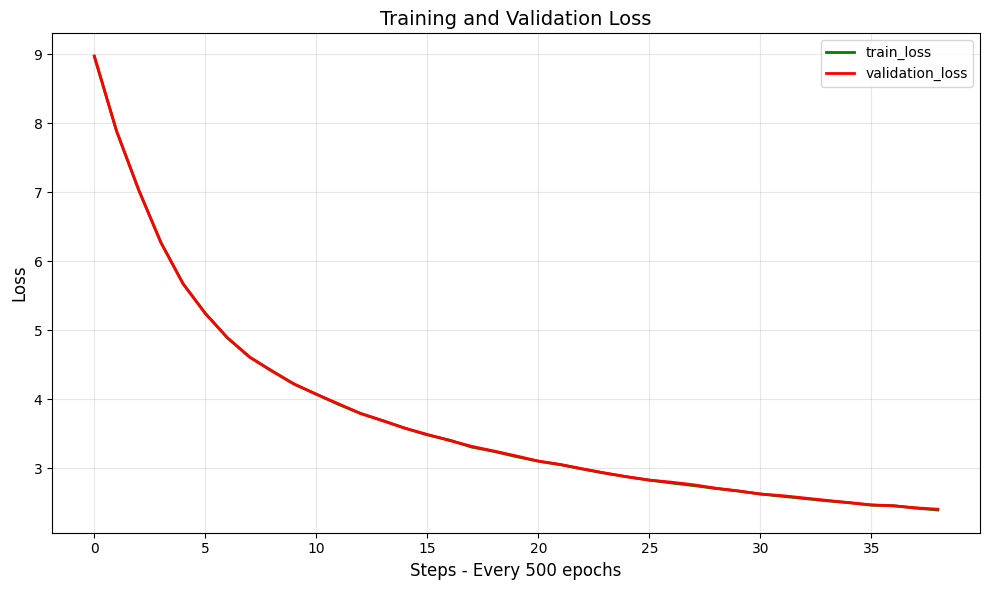

In [11]:
import matplotlib.pyplot as plt

if len(train_loss_list) > 0:
    train_loss_list_converted = [i.cpu().detach() if torch.is_tensor(i) else i for i in train_loss_list]
    validation_loss_list_converted = [i.cpu().detach() if torch.is_tensor(i) else i for i in validation_loss_list]

    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_list_converted, 'g', label='train_loss', linewidth=2)
    plt.plot(validation_loss_list_converted, 'r', label='validation_loss', linewidth=2)
    plt.xlabel(f"Steps - Every {eval_iters} epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training and Validation Loss", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No loss data to plot yet. Train for at least one evaluation interval.")

In [12]:
enc = tiktoken.get_encoding("gpt2")

model = GPT(config)
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device)))
model = model.to(device)
model.eval()

print("Best model loaded successfully!")
print(f"Model is on device: {next(model.parameters()).device}")

Best model loaded successfully!
Model is on device: cuda:0


In [13]:
sentence = "Once upon a time there was a pumpkin."
print(f"Prompt: {sentence}\n")

context = torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim=0).to(device)
y = model.generate(context, 200, temperature=1.0, top_k=50)
generated_text = enc.decode(y.squeeze().tolist())

print("Generated text:")
print("="*70)
print(generated_text)
print("="*70)

Prompt: Once upon a time there was a pumpkin.

Generated text:
Once upon a time there was a pumpkin. It was a big, hairy potato! The pumpkin was scared and wanted to know what was going. 

When she got to the farm, the chicken noticed something. The queen began to panic and asked what was in. She warned the corn, "A cow, just like any friends about the corn, so everything are not nice enough. What's this?" 

A man asked, "It's okay, little rabbit," "The pig was just trying to rest for a long time. It's good to rest to the market."

Sandy nodded and then asked her dad where they could go and she got in. 

"It's okay," she said. "We'll save to the chicken for dinner!"

So she quickly started to get off the cows. Together, the farm and the chickens ate in the wheat water and made some some yummy food for them.

Silly decided to make a plan to find a friends to help


In [14]:
sentence = "A little girl went to the woods"
print(f"Prompt: {sentence}\n")

context = torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim=0).to(device)
y = model.generate(context, 200, temperature=1.0, top_k=50)
generated_text = enc.decode(y.squeeze().tolist())

print("Generated text:")
print("="*70)
print(generated_text)
print("="*70)

Prompt: A little girl went to the woods

Generated text:
A little girl went to the woods and asked her mother what she had seen. His mother told her he was so sad and decided to be careful. She told her to be careful and respectful. Her dad decided to hold the flashlight when she got there a little bit more attention.

Mary was shocked outside and she started to cry. Her parents were still worried that they were going to get late. Jane never found something else. She was safe with a cozy place that she would come back to sleep and sleep next time.Once upon a time, there was a little girl who loved to play. Sometimes day, her toys would come out and wear a big, warm warm sun, cozy asleep in the sky.

One day, the little girl invited her mom in a big house. Her mom was so excited for her adventure and they started spinning with her dolls.

When the house arrived, Lily knew that her mom would be safe and never forget to stop working and make her feel sad. Even though she couldn
